In [446]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv('cluster_raw.dat', sep='\t')
data = data.drop(['Unnamed: 0'], axis=1)


In [447]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

schoice = 0
if schoice == 0:
    scaler = StandardScaler()
else:
    scaler = MinMaxScaler()

scaled = scaler.fit_transform(data)
data  = pd.DataFrame(scaled, columns=['x0', 'x1', 'x2', 'x3', 'x4'])

,x0,x1,x2,x3,x4
0,-0.415059,0.806866,-1.008166,-0.241285,0.366299
1,-0.923750,0.099160,1.431151,1.317042,-0.485329
2,-0.410293,0.279732,-1.007486,-0.274126,0.089920
3,-0.918225,-0.062956,1.205391,0.656491,-0.504675
4,-0.395334,0.141584,-1.006120,-0.285453,-0.018395


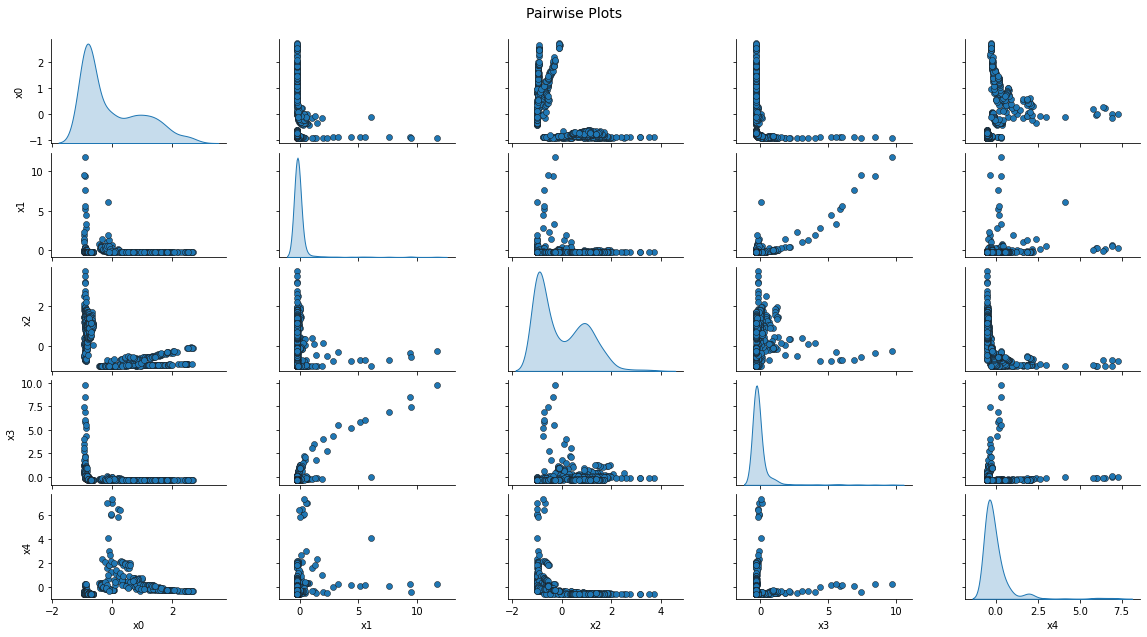

In [448]:
import seaborn as sns

cols = ['x0', 'x1', 'x2', 'x3', 'x4']
pp = sns.pairplot(data[cols], height=1.8, aspect=1.8,
    plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kind="kde", diag_kws=dict(shade=True))

fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Pairwise Plots', fontsize=14)

fig.savefig("cluster_pairwise.tiff")

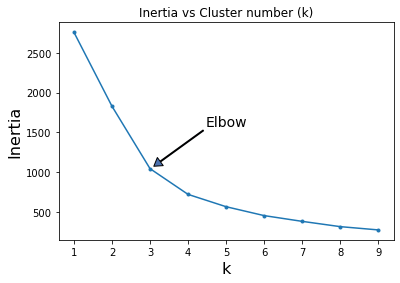

In [449]:
from sklearn.cluster import KMeans

kmax = 7
kmeans_per_k = [KMeans(n_clusters=k, init='k-means++',
                       n_init=10, tol=1e-4,
                       random_state=42).fit(data)
                for k in range(1, kmax)]
inertias = [model.inertia_ for model in kmeans_per_k]

fig, ax = plt.subplots(1,1, figsize=(6,4))
fsize_label = 16
fsize_title = 18
xticks = np.arange(1,kmax)
ax.plot(xticks, inertias, '-', marker='.')
ax.set_xlabel('k', fontsize=fsize_label)
ax.set_ylabel('Inertia', fontsize=fsize_label)
ax.set_title('Inertia vs Cluster number (k)')
plt.xticks(np.arange(1, kmax))
ax.annotate('Elbow', xy=(3+0.1,inertias[2]+30),
            xytext=(5,inertias[3]+1000), 
            arrowprops=dict(facecolor='b',
            headwidth=10, width=1, headlength=8),
            horizontalalignment='center', verticalalignment='top',
            fontsize=14)
fig.savefig('cluster_inertia.tiff')

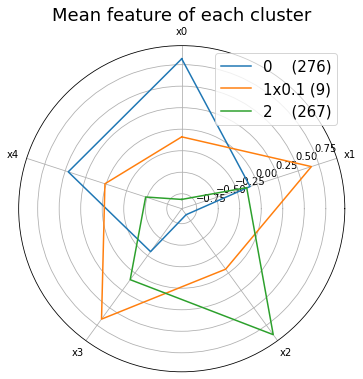

In [461]:
n_clusters = 3

kmeans = KMeans(
    n_clusters=n_clusters, init="k-means++",
    n_init=10,
    tol=1e-04, random_state=42
)
kmeans.fit(data)
clusters = data.copy()
clusters['label'] = kmeans.labels_
features = data.columns

plt.figure(figsize=(12, 6))
plt.subplot(polar=True)
cluster_mean = clusters.groupby("label").mean().reset_index()
cluster_mean = pd.melt(cluster_mean, id_vars=["label"])
cluster_size = clusters.groupby("label").size().reset_index()
cluster_size.columns = ['label', 'value']

thetas = np.arange(90, -270, -int(360)/len(features))
thetas = np.where(thetas<0, thetas+360, thetas)
thetas = thetas.tolist()
thetas.append(thetas[0])
thetas_rad = [x*np.pi/180 for x in thetas]
lines, labels = plt.thetagrids(thetas[:len(features)], features)

for i in range(n_clusters):
    values = cluster_mean[cluster_mean.label==i].value.tolist()
    values.append(values[0])
    if i==1:
        values = [x*0.1 for x in values]
        label = str(i)+"x0.1 ("+str(cluster_size.value[i])+")"
    else:
        label = str(i)+"    ("+str(cluster_size.value[i])+")"
    plt.plot(thetas_rad, values, label=label)
    
plt.legend(loc='best', prop={'size': 15})
plt.title("Mean feature of each cluster", fontsize=18)
plt.savefig('cluster_polar.jpg')

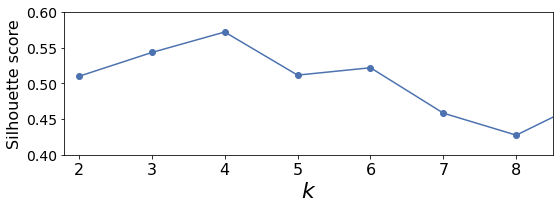

In [451]:
from sklearn.metrics import silhouette_score

silhouette_score(data, kmeans.labels_)
silhouette_scores = [silhouette_score(data, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=22)
plt.ylabel("Silhouette score", fontsize=16)
plt.axis([1.8, 8.5, 0.4, 0.6])
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
ax.set_title("Silhouette score vs cluster number")
plt.tight_layout()
plt.savefig("cluster_silhouette_score.tiff")

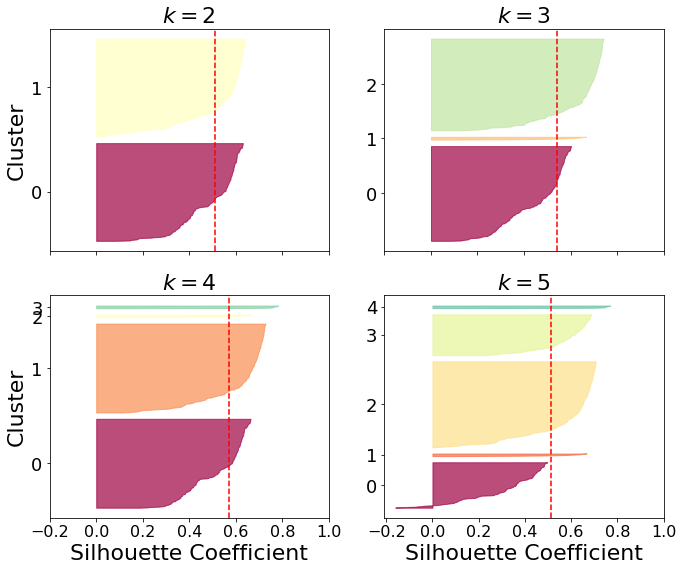

In [459]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib as mpl

plt.figure(figsize=(11, 9))

for k in (2, 3, 4, 5):
    plt.subplot(2, 2, k - 1)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(data, y_pred)

    padding = len(data) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (2, 4):
        plt.ylabel("Cluster", fontsize=22)
    if k in (4, 5):
         plt.xlabel("Silhouette Coefficient", fontsize=22)
    else:
        plt.tick_params(labelbottom=False)
 
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=18)
    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=22)

plt.savefig("cluster_silhouette_analysis.tiff")

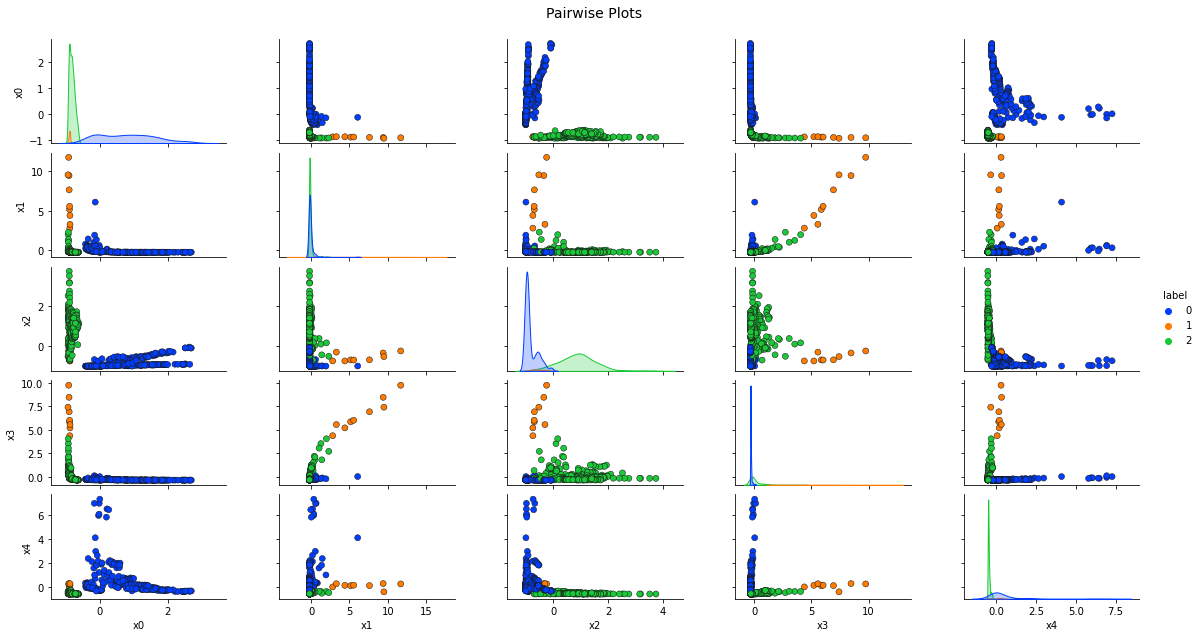

In [453]:
pp = sns.pairplot(clusters, height=1.8, aspect=1.8,
                  plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kind="kde", diag_kws=dict(shade=True),
                  hue="label", palette="bright")
fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Pairwise Plots', fontsize=14)

fig.savefig("cluster_pairwise_clustered.tiff")